# normalize edilmiş kod

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
import os
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, balanced_accuracy_score,
                            f1_score, accuracy_score, precision_score,
                            confusion_matrix)
import matplotlib.pyplot as plt
import json
import time
from tqdm import tqdm

warnings.filterwarnings("ignore")

# ####################################################
#  VERI KLASÖRÜ
# ####################################################
path = '/content/drive/MyDrive/Data'
print(f"Dataset Path: {path}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')



Dataset Path: /content/drive/MyDrive/Data
Using device: cpu


In [ ]:

# ----------------------------------------------------
# DATASET SINIFI
# ----------------------------------------------------
class EmotionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # grayscale
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# ----------------------------------------------------
# DATASET YÜKLEME
# ----------------------------------------------------
def load_dataset(data_path):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(data_path))
    class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(data_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(img_path)
                    labels.append(class_to_idx[class_name])

    return image_paths, labels, class_names

print("Loading dataset...")
image_paths, labels, class_names = load_dataset(path)
print(f"Total images: {len(image_paths)}")
print(f"Classes: {class_names}")




Loading dataset...
Total images: 59099
Classes: ['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']


In [ ]:
# ----------------------------------------------------
# TRAIN / VAL / TEST SPLIT (70 / 10 / 20)
# ----------------------------------------------------
X_temp, X_test, y_temp, y_test = train_test_split(
    image_paths, labels, test_size=0.2, random_state=123, stratify=labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=123, stratify=y_temp
)

print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")




Train size: 41369, Val size: 5910, Test size: 11820


In [ ]:
# ----------------------------------------------------
# TRANSFORMS (NORMALIZATION EKLENDİ)
# ----------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])   # ⭐ NORMALIZATION EKLENDİ
])


train_dataset = EmotionDataset(X_train, y_train, transform=transform)
val_dataset = EmotionDataset(X_val, y_val, transform=transform)
test_dataset = EmotionDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


# ----------------------------------------------------
# MODEL
# ----------------------------------------------------
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(EmotionCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.3)

        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)

        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.bn7 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout1(x)

        x = self.relu(self.bn5(self.conv5(x)))
        x = self.pool3(x)

        x = self.relu(self.bn6(self.conv6(x)))
        x = self.pool4(x)

        x = self.flatten(x)
        x = self.relu(self.bn7(self.fc1(x)))
        x = self.dropout2(x)
        x = self.fc2(x)

        return x


model = EmotionCNN(num_classes=len(class_names)).to(device)
print(model)




EmotionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.3, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(128, eps=1

In [ ]:
# ----------------------------------------------------
# LOSS / OPTIMIZER
# ----------------------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3
)


# ----------------------------------------------------
# TRAIN + VAL FONKSİYONLARI
# ----------------------------------------------------
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for inputs, labels in tqdm(dataloader, desc='Training', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    return running_loss / total, correct / total


def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Validation', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()

    return running_loss / total, correct / total


# ----------------------------------------------------
# TRAINING LOOP
# ----------------------------------------------------
print("\nTraining started...")
num_epochs = 50
patience = 5
best_val_loss = float('inf')
patience_counter = 0

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    start_time = time.time()

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    epoch_time = time.time() - start_time

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} || "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} || "
        f"Epoch Time: {epoch_time:.2f} sec"
    )

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Best model saved (Val Loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break





Training started...

Epoch 1/50


Train Loss: 1.1669 | Train Acc: 0.5249 || Val Loss: 0.9571 | Val Acc: 0.6179 || Epoch Time: 3958.33 sec
Best model saved (Val Loss: 0.9571)

Epoch 2/50


Train Loss: 0.8669 | Train Acc: 0.6598 || Val Loss: 0.8671 | Val Acc: 0.6541 || Epoch Time: 196.57 sec
Best model saved (Val Loss: 0.8671)

Epoch 3/50


Train Loss: 0.7109 | Train Acc: 0.7253 || Val Loss: 0.7607 | Val Acc: 0.7019 || Epoch Time: 194.85 sec
Best model saved (Val Loss: 0.7607)

Epoch 4/50


Train Loss: 0.5714 | Train Acc: 0.7852 || Val Loss: 0.7027 | Val Acc: 0.7413 || Epoch Time: 196.39 sec
Best model saved (Val Loss: 0.7027)

Epoch 5/50


Train Loss: 0.4294 | Train Acc: 0.8475 || Val Loss: 0.5758 | Val Acc: 0.7993 || Epoch Time: 195.73 sec
Best model saved (Val Loss: 0.5758)

Epoch 6/50


Train Loss: 0.3259 | Train Acc: 0.8854 || Val Loss: 0.5474 | Val Acc: 0.8208 || Epoch Time: 196.24 sec
Best model saved (Val Loss: 0.5474)

Epoch 7/50


Train Loss: 0.2335 | Train Acc: 0.9212 || Val Loss: 0.4690 | Val Acc: 0.8558 || Epoch Time: 197.24 sec
Best model saved (Val Loss: 0.4690)

Epoch 8/50


Train Loss: 0.1796 | Train Acc: 0.9408 || Val Loss: 0.4976 | Val Acc: 0.8616 || Epoch Time: 200.68 sec

Epoch 9/50


Train Loss: 0.1382 | Train Acc: 0.9552 || Val Loss: 0.4364 | Val Acc: 0.8848 || Epoch Time: 194.86 sec
Best model saved (Val Loss: 0.4364)

Epoch 10/50


Train Loss: 0.1147 | Train Acc: 0.9647 || Val Loss: 0.4307 | Val Acc: 0.8963 || Epoch Time: 198.10 sec
Best model saved (Val Loss: 0.4307)

Epoch 11/50


Train Loss: 0.0995 | Train Acc: 0.9694 || Val Loss: 0.4565 | Val Acc: 0.8893 || Epoch Time: 194.64 sec

Epoch 12/50


Train Loss: 0.0892 | Train Acc: 0.9715 || Val Loss: 0.4685 | Val Acc: 0.8926 || Epoch Time: 193.72 sec

Epoch 13/50


Train Loss: 0.0790 | Train Acc: 0.9751 || Val Loss: 0.5587 | Val Acc: 0.8809 || Epoch Time: 194.15 sec

Epoch 14/50


Train Loss: 0.0738 | Train Acc: 0.9768 || Val Loss: 0.4848 | Val Acc: 0.8888 || Epoch Time: 193.91 sec

Epoch 15/50


Train Loss: 0.0454 | Train Acc: 0.9881 || Val Loss: 0.4549 | Val Acc: 0.8954 || Epoch Time: 193.69 sec

Early stopping triggered at epoch 15



Best model loaded!
Training history saved!


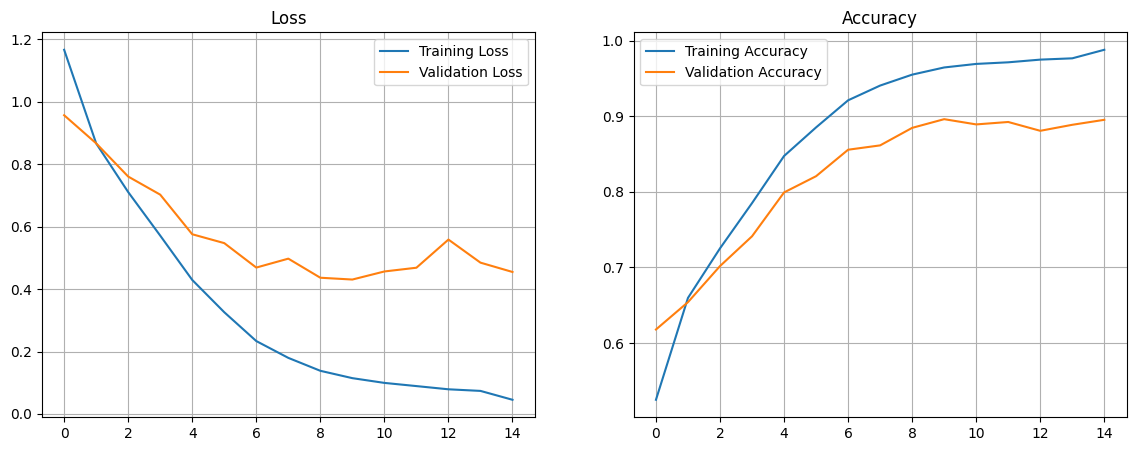


TEST SET RESULTS


KeyboardInterrupt: 

In [ ]:
# ----------------------------------------------------
# BEST MODEL YÜKLE
# ----------------------------------------------------
model.load_state_dict(torch.load('best_model.pth'))
print("\nBest model loaded!")

with open('training_history.json', 'w') as f:
    json.dump(history, f)

print("Training history saved!")


# ----------------------------------------------------
# PLOT
# ----------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(history['train_loss'], label='Training Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.legend(); ax1.grid(); ax1.set_title("Loss")

ax2.plot(history['train_acc'], label='Training Accuracy')
ax2.plot(history['val_acc'], label='Validation Accuracy')
ax2.legend(); ax2.grid(); ax2.set_title("Accuracy")

plt.show()




In [ ]:
# ----------------------------------------------------
# TEST
# ----------------------------------------------------
def evaluate_test(model, dataloader, device):
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, pred = outputs.max(1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(pred.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)


print("\nTEST SET RESULTS")
y_true, y_pred = evaluate_test(model, test_loader, device)

print(classification_report(y_true, y_pred, target_names=class_names))


TEST SET RESULTS


NameError: name 'model' is not defined